In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers

In [ ]:
# Load the dataset
df = pd.read_csv("maternal_health.csv")

# Display basic info about the dataset
print(df.info())
print(df.head())

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Drop or fill missing values (choosing mean for numerical columns)
df.fillna(df.select_dtypes(include=['number']).mean(), inplace=True)

# Define class names based on encoded risk levels
class_names = ["Low Risk", "Mid Risk", "High Risk"]

# Encoding categorical variable 'RiskLevel' (Target Variable)
risk_mapping = {"low risk": 0, "mid risk": 1, "high risk": 2}
df["RiskLevel"] = df["RiskLevel"].map(risk_mapping)

x = df.drop("RiskLevel", axis=1)
y = df["RiskLevel"]

# Standardize numerical features (important for models like Logistic Regression, SVM)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

#
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", x_train.shape)
print("Testing set size:", x_test.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None
   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk
Missing values:
 Age        

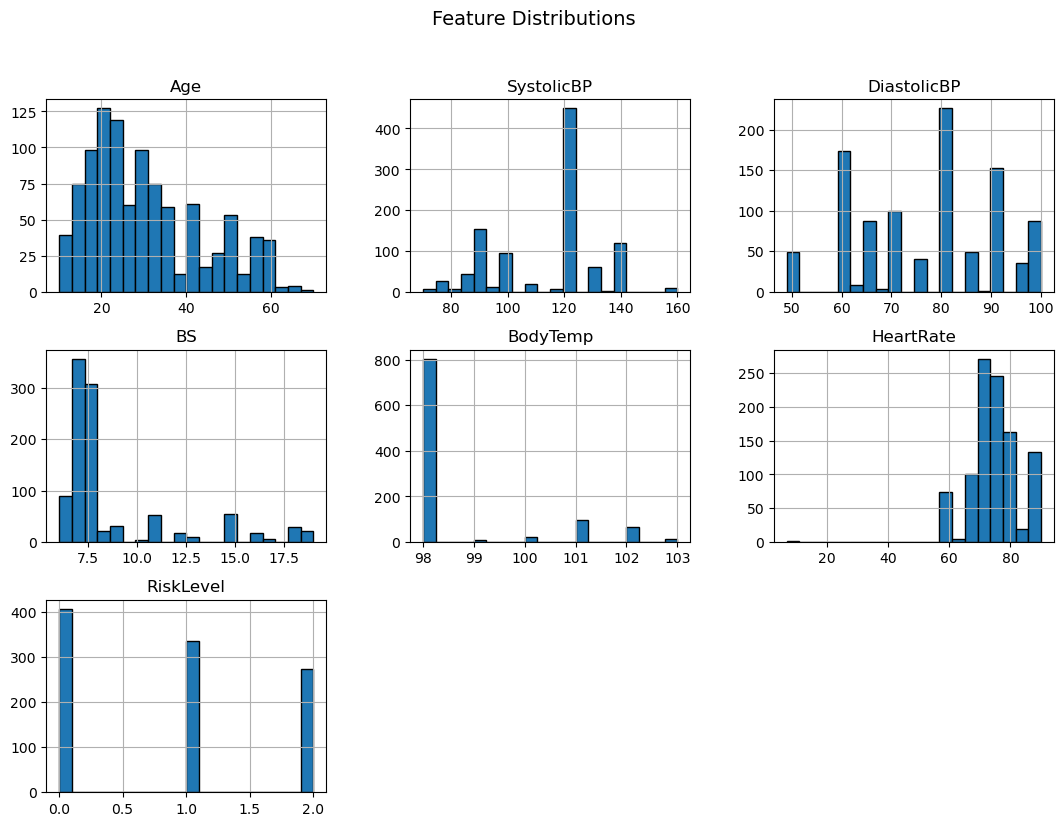

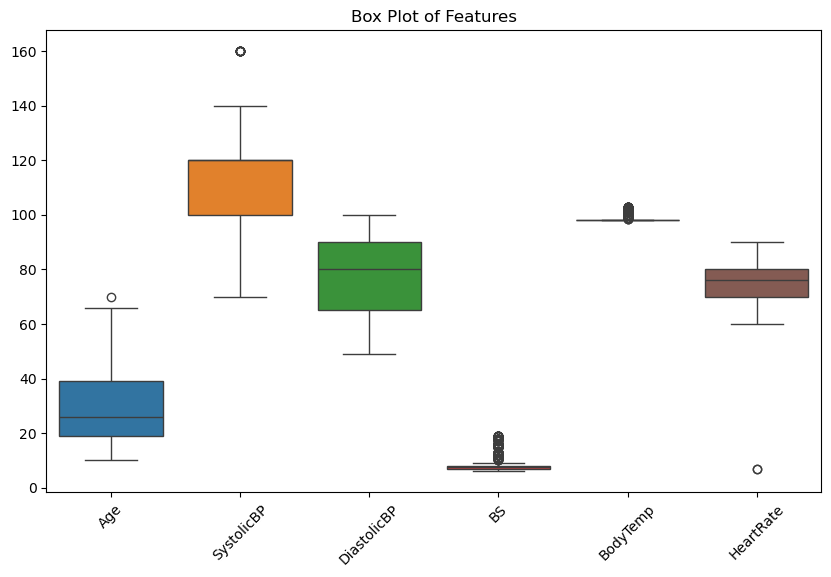

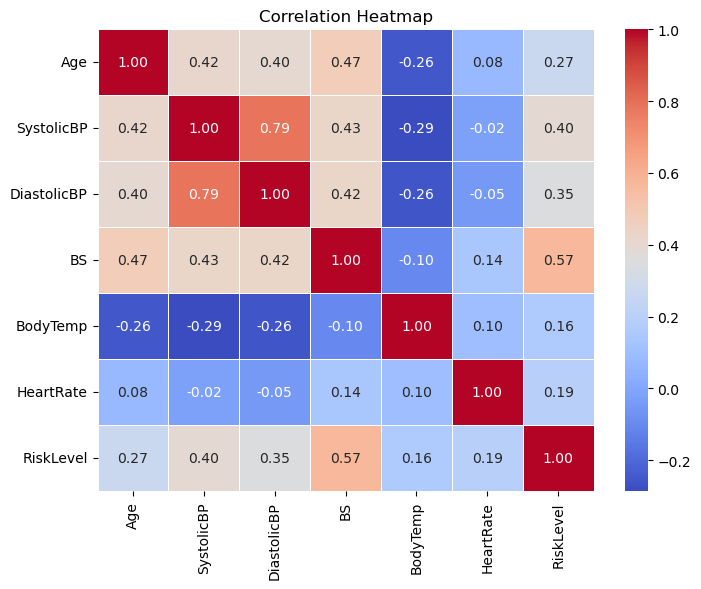

In [35]:
# Visualisations for dataset 
#1. Histogram of Features (Distribution of Data)
df.hist(figsize=(13, 9), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=14)
plt.savefig("histogram_features.png", dpi=300)
plt.show()

#2. Box Plot (Detect Outliers in Features)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp", "HeartRate"]])
plt.title("Box Plot of Features")
plt.xticks(rotation=45) 
plt.savefig("box_plot.png", dpi=300)
plt.show()

#5. Correlation Heatmap (Feature Relationships)
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.savefig("heatmap.png", dpi=300)
plt.show()

RandomForestClassifier Accuracy: 85.22%


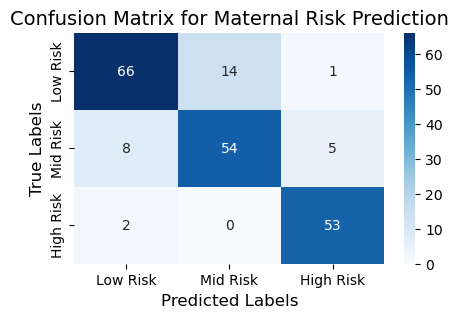


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        81
           1       0.79      0.81      0.80        67
           2       0.90      0.96      0.93        55

    accuracy                           0.85       203
   macro avg       0.85      0.86      0.86       203
weighted avg       0.85      0.85      0.85       203



In [23]:
# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training set
rf_model.fit(x_train, y_train)

# Make predictions on the test set
true_labels = y_test  # True labels from the test dataset
predicted_labels = rf_model.predict(x_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, predicted_labels)
conf_matrix = confusion_matrix(y_test, predicted_labels)
class_report = classification_report(y_test, predicted_labels)

# Print evaluation results
print(f"RandomForestClassifier Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Maternal Risk Prediction', fontsize=14)
plt.show()

print("\nClassification Report:")
print(class_report)

Base accuracy: 84.24%
Removed 'Age': Accuracy = 83.74%, Change = +0.49%
Removed 'SystolicBP': Accuracy = 84.73%, Change = -0.49%
Removed 'DiastolicBP': Accuracy = 84.24%, Change = +0.00%
Removed 'BS': Accuracy = 73.40%, Change = +10.84%
Removed 'BodyTemp': Accuracy = 83.74%, Change = +0.49%
Removed 'HeartRate': Accuracy = 84.24%, Change = +0.00%


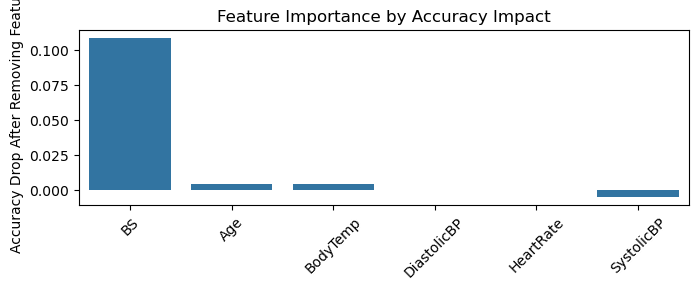

In [37]:
# Store accuracy drop for each feature
feature_importance_effect = {}

# Use the actual feature names from your dataset
feature_names = ["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp","HeartRate"]

# Calculate base accuracy first
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(x_train, y_train)
y_pred_base = rf_base.predict(x_test)
base_accuracy = accuracy_score(y_test, y_pred_base)
print(f"Base accuracy: {base_accuracy * 100:.2f}%")

# Check feature importance by removing one feature at a time
for i, feature in enumerate(feature_names):
    # Create arrays without the current feature
    x_train_reduced = np.delete(x_train, i, axis=1)
    x_test_reduced = np.delete(x_test, i, axis=1)
    
    # Train new model
    rf_temp = RandomForestClassifier(random_state=42)
    rf_temp.fit(x_train_reduced, y_train)
    
    # Predict and evaluate
    y_pred_temp = rf_temp.predict(x_test_reduced)
    temp_accuracy = accuracy_score(y_test, y_pred_temp)
    
    # Calculate accuracy drop
    drop = base_accuracy - temp_accuracy
    feature_importance_effect[feature] = drop
    
    print(f"Removed '{feature}': Accuracy = {temp_accuracy * 100:.2f}%, Change = {drop * 100:+.2f}%")

# -------------------------------
# 3. Sort features by impact
sorted_features = sorted(feature_importance_effect.items(), key=lambda x: x[1], reverse=True)
features, drops = zip(*sorted_features)
plt.figure(figsize=(7, 3))
sns.barplot(x=list(features), y=list(drops))
plt.xticks(rotation=45)
plt.ylabel("Accuracy Drop After Removing Feature")
plt.title("Feature Importance by Accuracy Impact")
plt.tight_layout()
plt.show()

Decision Tree Accuracy: 69.95%


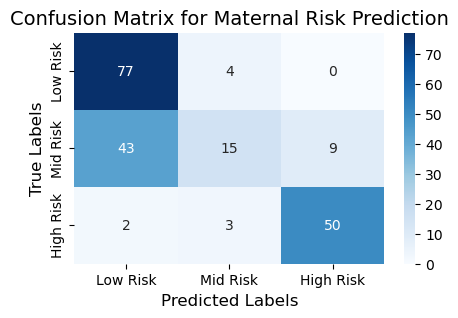

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.95      0.76        81
           1       0.68      0.22      0.34        67
           2       0.85      0.91      0.88        55

    accuracy                           0.70       203
   macro avg       0.72      0.69      0.66       203
weighted avg       0.71      0.70      0.65       203



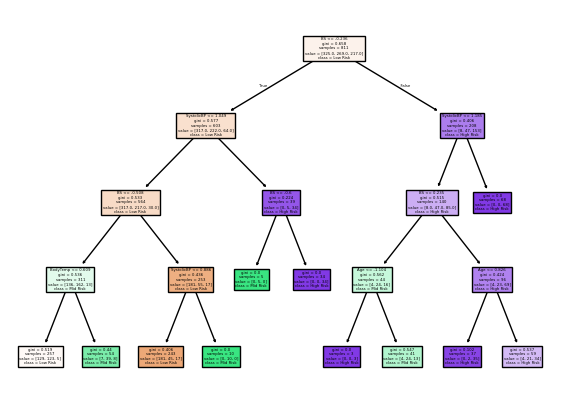

In [29]:
# Create Decision Tree model
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)  

# Train the model
dt_model.fit(x_train, y_train)

# Make predictions
y_pred = dt_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Maternal Risk Prediction', fontsize=14)
plt.show()
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot Decision Tree
plt.figure(figsize=(7,5))
tree.plot_tree(dt_model, feature_names=x.columns, class_names=["Low Risk", "Mid Risk", "High Risk"], filled=True)
plt.show()

In [31]:
# Convert target variable to categorical (one-hot encoding)
y_categorical = to_categorical(y, num_classes=3)

# Split dataset again with categorical target
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_categorical, test_size=0.2, random_state=42, stratify=y)

# We need to define the neural network
model = models.Sequential([
    # Input Layer
    layers.Input(shape=(x_train.shape[1],)),  # Define the input shape

    # First hidden layer
    layers.Dense(32, activation='relu'),   

    # Second hidden layer
    layers.Dense(64, activation='relu'),  

    # Dropout Layer to prevent overfitting 
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(3, activation='softmax')
])

# We want to print the model summary
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=10, verbose=1)

# Evaluate model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Neural Network Accuracy: {accuracy * 100:.2f}%")

# Generate Predictions
y_pred_probs = model.predict(x_test)  # Predict probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoding back to class labels

# Print Classification Report
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=["low risk", "mid risk", "high risk"]))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,531 (9.89 KB)

 Trainable params: 2,531 (9.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5261 - loss: 0.9612 - val_accuracy: 0.7094 - val_loss: 0.6963
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6575 - loss: 0.7482 - val_accuracy: 0.7094 - val_loss: 0.7023
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6461 - loss: 0.7399 - val_accuracy: 0.6749 - val_loss: 0.6783
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6371 - loss: 0.6935 - val_accuracy: 0.6798 - val_loss: 0.7088
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6589 - loss: 0.7002 - val_accuracy: 0.6897 - val_loss: 0.6397
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6898 - loss: 0.6447 - val_accuracy: 0.6946 - val_loss: 0.6484
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6919 - loss: 0.6737 - val_accuracy: 0.6847 - val_loss: 0.6289
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6691 - loss: 0.6514 - val_accuracy: 0.6749 - val_loss:

In [45]:
# New input features for a mother
# Make sure to input values in the same order as the features in the training data
new_input = np.array([[30, 120, 80, 5.5, 100, 75]]) 

# Convert new_input into a DataFrame with column names
new_input_df = pd.DataFrame(new_input, columns=["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp", "HeartRate"])

# Standardize the new input (same scaling used during training)
new_input_scaled = scaler.transform(new_input_df)

# Predict the risk level
predicted_risk = rf_model.predict(new_input_scaled)

# Map the prediction back to the corresponding string risk level (low, mid, high)
risk_mapping_reverse = {0: "low risk", 1: "mid risk", 2: "high risk"}
predicted_risk_level = risk_mapping_reverse[predicted_risk[0]]

print(f"The predicted risk level is: {predicted_risk_level}")

The predicted risk level is: mid risk
